In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import convex_hull_image

In [2]:
img = cv2.imread('Data/CHP/1/img020.bmp', cv2.IMREAD_COLOR)
print(img.shape)

(378, 378, 3)


In [3]:
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

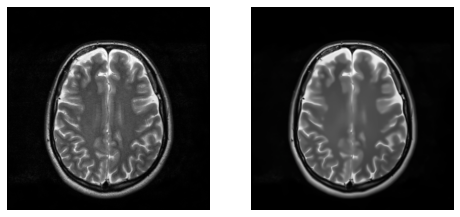

In [4]:
fig1=plt.figure(figsize = (8,8))
a = fig1.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray',vmin=0,vmax=2**8)
plt.axis('off');

b = fig1.add_subplot(1, 2, 2)
plt.imshow(dst, cmap='gray',vmin=0,vmax=2**8)
plt.axis('off');

/tmp/ipykernel_8227/3941244932.py:3: RuntimeWarning: divide by zero encountered in log
  Iout=np.log(img[:,:]+1)


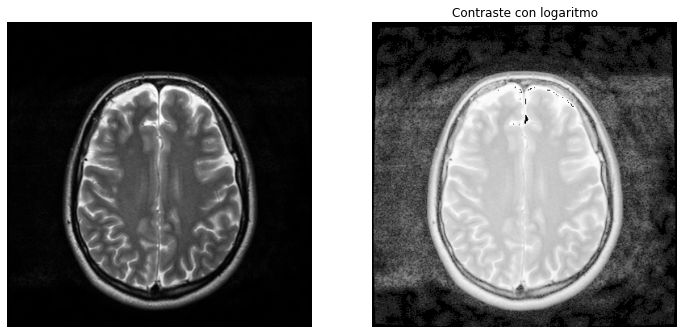

In [5]:
inmax=np.amax(img)
c=255/(np.log(1+inmax))
Iout=np.log(img[:,:]+1)
Iout=c*Iout[:,:]
Iout=Iout.astype(np.uint8)


fig1=plt.figure(figsize = (12,12))
a = fig1.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray',vmin=0,vmax=2**8)
plt.axis('off');

b = fig1.add_subplot(1,2,2)
plt.imshow(Iout, cmap = 'gray', vmin=0, vmax=255)
plt.axis('off')
b.set_title('Contraste con logaritmo');

min= 0 max= 254


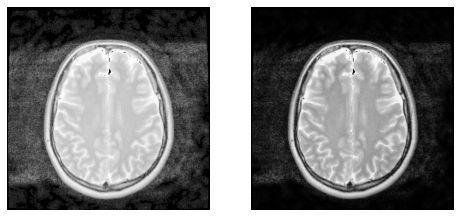

In [6]:
##CONTRASTRE CON CORRECCIÓN GAMMA
x=np.linspace(0, 255, num=256)
vg=np.array([0.05, 0.1,0.2, 0.5, 1, 2, 5, 10]) 
for i in vg:
    c=255/(255**i)
    gamma=c*(x**i)

maxi = np.amax(Iout)
vg=1.8  #Change the gamma value
c=255/(maxi**vg)
I2=c*np.float32(Iout)**vg
I2=I2.astype(np.uint8)
inmax = np.amax(I2)
inmin = np.amin(I2)
print('min=',inmin,'max=',inmax)

fig5=plt.figure(figsize = (8,8))
a = fig5.add_subplot(1, 2, 1)
plt.imshow(Iout, cmap='gray',vmin=0,vmax=2**8)
plt.axis('off');

b = fig5.add_subplot(1, 2, 2)
plt.imshow(I2, cmap='gray',vmin=0,vmax=2**8)
plt.axis('off');



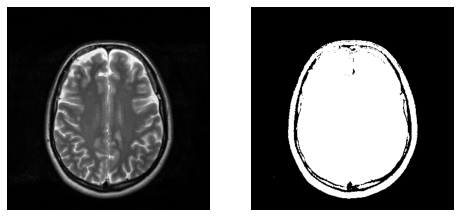

In [7]:
def binariza(imagem,Cerebro=True):
    if Cerebro:
        t = threshold_otsu(imagem)
    else:#Crânio
        t = 0
    imagem_binaria = imagem.copy()
    imagem_binaria[imagem_binaria<=t] = 0
    imagem_binaria[imagem_binaria>t] = 255
    return imagem_binaria

Gbin = binariza(cv2.cvtColor(I2,cv2.COLOR_BGR2GRAY))
fig6=plt.figure(figsize = (8,8))
a = fig6.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray',vmin=0,vmax=2**8)
plt.axis('off');

b = fig6.add_subplot(1, 2, 2)
plt.imshow(Gbin, cmap='gray',vmin=0,vmax=2**8)
plt.axis('off');



#plt.imshow(Gbin,'gray')

tonalidad de fondo: 0
max_centro: 1


Text(0.5, 1.0, 'Componentes Conexas(labels)')

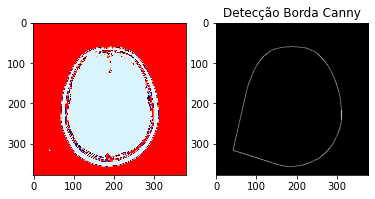

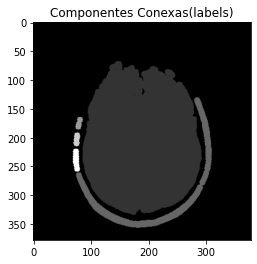

In [8]:
from PIL import Image
from scipy import signal as sci
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_fill_holes, binary_opening
%matplotlib inline
import matplotlib.image as mpimg
from skimage import morphology as morph
from scipy import ndimage as nd
import sys,os
from skimage.filters import threshold_otsu, threshold_isodata, threshold_li, threshold_local, threshold_minimum 
from skimage import feature
from skimage.filters import threshold_local as threshold_adaptative
import heapq
import matplotlib.patches as mpatches
from skimage.morphology import convex_hull_image
import pandas as pd
import seaborn as sns
from scipy.signal import convolve2d as sc_conv
from matplotlib.colors import colorConverter
import matplotlib as mpl
import time

def detecta_borda_conexa(imagem_binaria): 
    cranio_convexo = convex_hull_image(binary_fill_holes(imagem_binaria))# preenche a imagem
    borda_cranio = feature.canny(cranio_convexo)#extrai a borda
    return borda_cranio

def detecta_componente_conexa(imagem_binaria,mostrar_Passos=False):
    label_aux = morph.label(imagem_binaria)
    label_ret = morph.label(imagem_binaria)
    if mostrar_Passos==True:
        plt.figure()
        plt.subplot(121)
        plt.imshow(label_ret,'flag')
        #plt.title('Componentes Conexas(Labels)')
        #save_without_spacing("TrabalhoMeninge_7_"+str(0)+"comp.png")
    valor_disco = 0
    
    #Passo 1 - Detecção da Borda do Crânio via Canny
    contorno_cranio_binario = detecta_borda_conexa(imagem_binaria)
    if mostrar_Passos==True:
        plt.subplot(122)
        plt.imshow(contorno_cranio_binario,'gray')
        plt.title('Detecção Borda Canny')
        plt.figure()

    #Passo 2 - Detecção da Tonalidade do Fundo
    tonalidade_fundo = (np.argmax(np.bincount(label_ret[0:20,0:20].ravel())))
    print("tonalidad de fondo:",tonalidade_fundo)
    for ab in range(200):
        #print(ab)
        contorno_cranio = label_ret[contorno_cranio_binario==True]
        [IMX,IMY] = imagem_binaria.shape
        
        #Passo 3 - Detecção da Parte Central do Cérebro (sem fundo)
        array_centro = label_ret[IMX//2-25:IMX//2+25,IMY//2-25:IMY//2+25]
        array_centro = array_centro[array_centro!=tonalidade_fundo]
        max_centro = (np.argmax(np.bincount(array_centro.ravel())))# retorna o pixel mais frequente na imagem array_centro, correspondendo ao valor do cérebro

        #Passo 4 - Verificação da Presença da Intensidade da Borda no Centro 
        if(max_centro in contorno_cranio):
            valor_disco = valor_disco + 1
            label_ret = morph.opening(label_aux,morph.disk(valor_disco))
            label_ret = morph.label(label_ret) 
            #plt.imshow(label_ret)
            #save_without_spacing("TrabalhoMeninge_7_"+str(valor_disco)+"comp.png")            
        else:
            break
    print("max_centro:",max_centro)

    #print(valor_disco)
    if(valor_disco == 0):
        label_ret = label_aux
    return [label_ret,tonalidade_fundo, array_centro]

[LC,tonalidade_fundo,array_centro] = detecta_componente_conexa(Gbin,True)
plt.imshow(LC,'gray')
plt.title('Componentes Conexas(labels)')

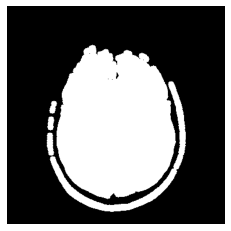

In [9]:
LCBin = binariza(LC,True)
plt.imshow(LCBin, cmap='gray')
plt.axis('off');

[       0. 10847700.  1267095.    49980.    56355.    97920.]
10847700.0
<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


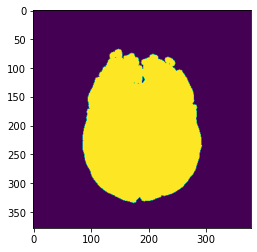

In [10]:
from scipy import ndimage
label_im, nb_labels = ndimage.label(LCBin)
nb_labels # how many regions?

plt.imshow(label_im)  

sizes = ndimage.sum(LCBin, label_im, range(nb_labels + 1))

print(sizes)
print(max(sizes))

mask_size = sizes < max(sizes)

remove_pixel = mask_size[label_im]
remove_pixel.shape

label_im[remove_pixel] = 0
plt.imshow(label_im)

print(type(label_im))
print(label_im)



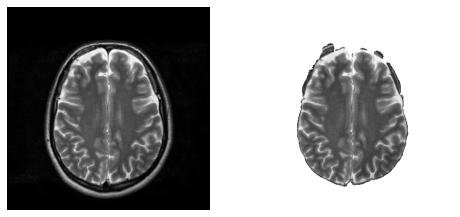

In [11]:
from skimage import color
imgGray = color.rgb2gray(img)
out = img.copy()
for i in range(label_im.shape[0]):
    for j in range(label_im.shape[1]):
        if(label_im[i][j]):
            out[i][j]=img[i][j]
        else:
            out[i][j]=255

fig6=plt.figure(figsize = (8,8))
a = fig6.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray',vmin=0,vmax=2**8)
plt.axis('off');

b = fig6.add_subplot(1, 2, 2)
plt.imshow(out, cmap='gray',vmin=0,vmax=2**8)
plt.axis('off');
